In [60]:
suppressWarnings(suppressMessages(library(tidyverse))) #ggplot and dplyr
suppressWarnings(suppressMessages(library(reshape2))) #melt
suppressWarnings(suppressMessages(require(gridExtra))) #Aggregate plots
suppressWarnings(suppressMessages(library(caret))) #evaluation metrics (such as confusion matrix)
suppressWarnings(suppressMessages(library(glmnet))) #ridge and lasso
suppressWarnings(suppressMessages(library(MASS))) #LDA QDA
suppressWarnings(suppressMessages(library(fastDummies))) #something like pd.dummies()
suppressWarnings(suppressMessages(library(InformationValue))) #evaluation metrics (ROC / AUC / Concordance) nao resultou, deu valores errados
suppressWarnings(suppressMessages(library(scales))) #scales for plots
suppressWarnings(suppressMessages(library(ROCR)))#Calculate and plot ROC curves and AUC
suppressWarnings(suppressMessages(library(amap)))#

In [61]:
suppressWarnings(suppressMessages(library(cluster)))   # clustering algorithms
suppressWarnings(suppressMessages(library(factoextra))) # clustering visualization
suppressWarnings(suppressMessages(library(dendextend)))
suppressWarnings(suppressMessages(library(fossil)))

suppressWarnings(suppressMessages(source(here::here("Help_Functions.r"))))

# Hierarchical Clustering
In this chapter we'll do 3 different experiments for each model, a reduced one and a complete one, where the reduced model is composed of the subset of features found using lasso regression.
The 3 experiments are:
    * Which dissimilarity measure should be used (pearson, euclidean,spearman,manhattan,cosine)
    * Which linkage type should be used (average,single,complete,ward)
    * Where should the dendogram be cut ( how many clusters)

## Complete model
As this is not a classification or regression problem there is no need to devided the dataset into training and testing and as such the whole dataset will be used

The **uci_heart** serves as the **complete** dataset.

Firstly we remove any missing values and scale the data

In [62]:
uci_heart = read_csv("heart.csv", col_types = c("nffnnffnfdffff"))

#remove wrong thal values
uci_heart = uci_heart[uci_heart$thal != 0, ]

uci_heart$thal = droplevels(uci_heart$thal, exclude = "0")

uci_heart$target = relevel(uci_heart$target, "0")
uci_heart$cp = relevel(uci_heart$cp, "1")

dim(uci_heart)
summary(uci_heart)

df = na.omit(uci_heart)

[1] 301  14

      age        sex     cp         trestbps          chol       fbs    
 Min.   :29.00   1:206   1: 50   Min.   : 94.0   Min.   :126.0   1: 44  
 1st Qu.:47.00   0: 95   3: 23   1st Qu.:120.0   1st Qu.:211.0   0:257  
 Median :56.00           2: 86   Median :130.0   Median :241.0          
 Mean   :54.38           0:142   Mean   :131.6   Mean   :246.5          
 3rd Qu.:61.00                   3rd Qu.:140.0   3rd Qu.:275.0          
 Max.   :77.00                   Max.   :200.0   Max.   :564.0          
 restecg    thalach      exang      oldpeak      slope   ca      thal   
 0:146   Min.   : 71.0   0:203   Min.   :0.000   0: 21   0:173   1: 18  
 1:151   1st Qu.:134.0   1: 98   1st Qu.:0.000   2:141   2: 38   2:166  
 2:  4   Median :153.0           Median :0.800   1:139   1: 65   3:117  
         Mean   :149.7           Mean   :1.043           3: 20          
         3rd Qu.:166.0           3rd Qu.:1.600           4:  5          
         Max.   :202.0           Max.   :6.200     

Then the data is scaled with mean 0 and standard deviation 1

In [63]:
ind <- sapply(df, is.numeric)
df[ind] <- lapply(df[ind], scale)

Here we separate the target from the rest of the data since we are working in a unsupervised setting. Later the target can be used to evaluate the clustering

In [64]:
dat = df[-14]
target = df$target

Next we calculate the 300*300 inter-observation matrix for each of the distances picked:
    * pearson
    * euclidean
    * spearman
    * manhattan
    * cosine

In [65]:
dist1 <- Dist(dat, method = "correlation")
dist2 <- Dist(dat, method = "euclidean")
dist3 <- Dist(dat, method = "spearman")
dist4 <- Dist(dat, method = "manhattan")

#dist 5 is cosine distance
Matrix <- data.matrix(dat)
sim <- Matrix / sqrt(rowSums(Matrix * Matrix))
sim <- sim %*% t(sim)
dist5 <- as.dist(1 - sim)

With the inter-observation matrices we can now create 4 models for each matrix, each one with a different linkage method for a total of **20** models

### Hierarchical clustering for pearson distance

In [66]:
hclus11 <- hclust(dist1, method = "complete")
hclus12 <- hclust(dist1, method = "single" )
hclus13 <- hclust(dist1, method = "average" )
hclus14 <- hclust(dist1, method = "ward.D2" )

### Hierarchical clustering for euclidean distance

In [67]:
hclus21 <- hclust(dist2, method = "complete")
hclus22 <- hclust(dist2, method = "single" )
hclus23 <- hclust(dist2, method = "average" )
hclus24 <- hclust(dist2, method = "ward.D2" )

### Hierarchical clustering for spearman distance

In [68]:
hclus31 <- hclust(dist3, method = "complete")
hclus32 <- hclust(dist3, method = "single" )
hclus33 <- hclust(dist3, method = "average" )
hclus34 <- hclust(dist3, method = "ward.D2" )

### Hierarchical clustering for manhattan distance

In [69]:
hclus41 <- hclust(dist4, method = "complete")
hclus42 <- hclust(dist4, method = "single" )
hclus43 <- hclust(dist4, method = "average" )
hclus44 <- hclust(dist4, method = "ward.D2" )

### Hierarchical clustering for cosine distance

In [70]:
hclus51 <- hclust(dist5, method = "complete")
hclus52 <- hclust(dist5, method = "single" )
hclus53 <- hclust(dist5, method = "average" )
hclus54 <- hclust(dist5, method = "ward.D2" )

### Selection of the number of clusters

In this project we choose **k=2** as the number of clusters since we are working with 2 classes (has heart disease, doesn't have heart disease). This doesn't however mean that the clusters we expect to find necessarilly match these two classes.

As such some of the tests will be done with this assumption (Recall, Precision, F1) and others will be done without it (adjusted rand index)

In [71]:
results_data = calculate_metrics_table()

agregation_coef = results_data$agregation_coef
rand_index = results_data$rand_index
precision = results_data$precision
recall = results_data$recall
f5 = results_data$f5

In [72]:
results_data

dissimilarity_measure,linkage_method,agregation_coef,rand_index,precision,recall,f5
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pearson,complete,0.9253947,0.132114207,0.43065693,0.7763158,0.7530682
pearson,single,0.7063227,0.001093845,1.00000000,0.4566667,0.4664135
pearson,average,0.8794493,0.001309421,0.99270073,0.4533333,0.4630090
pearson,ward,0.9792994,0.335496274,0.35766423,0.2462312,0.2492175
euclidean,complete,0.8074571,0.001093845,1.00000000,0.4566667,0.4664135
euclidean,single,0.5541507,0.001093845,1.00000000,0.4566667,0.4664135
euclidean,average,0.7405769,0.001093845,1.00000000,0.4566667,0.4664135
euclidean,ward,0.9333129,0.290687473,0.34306569,0.2486772,0.2513369
spearman,complete,0.9333175,0.222323679,0.49635036,0.3076923,0.3122572


### Clustering Dendograms

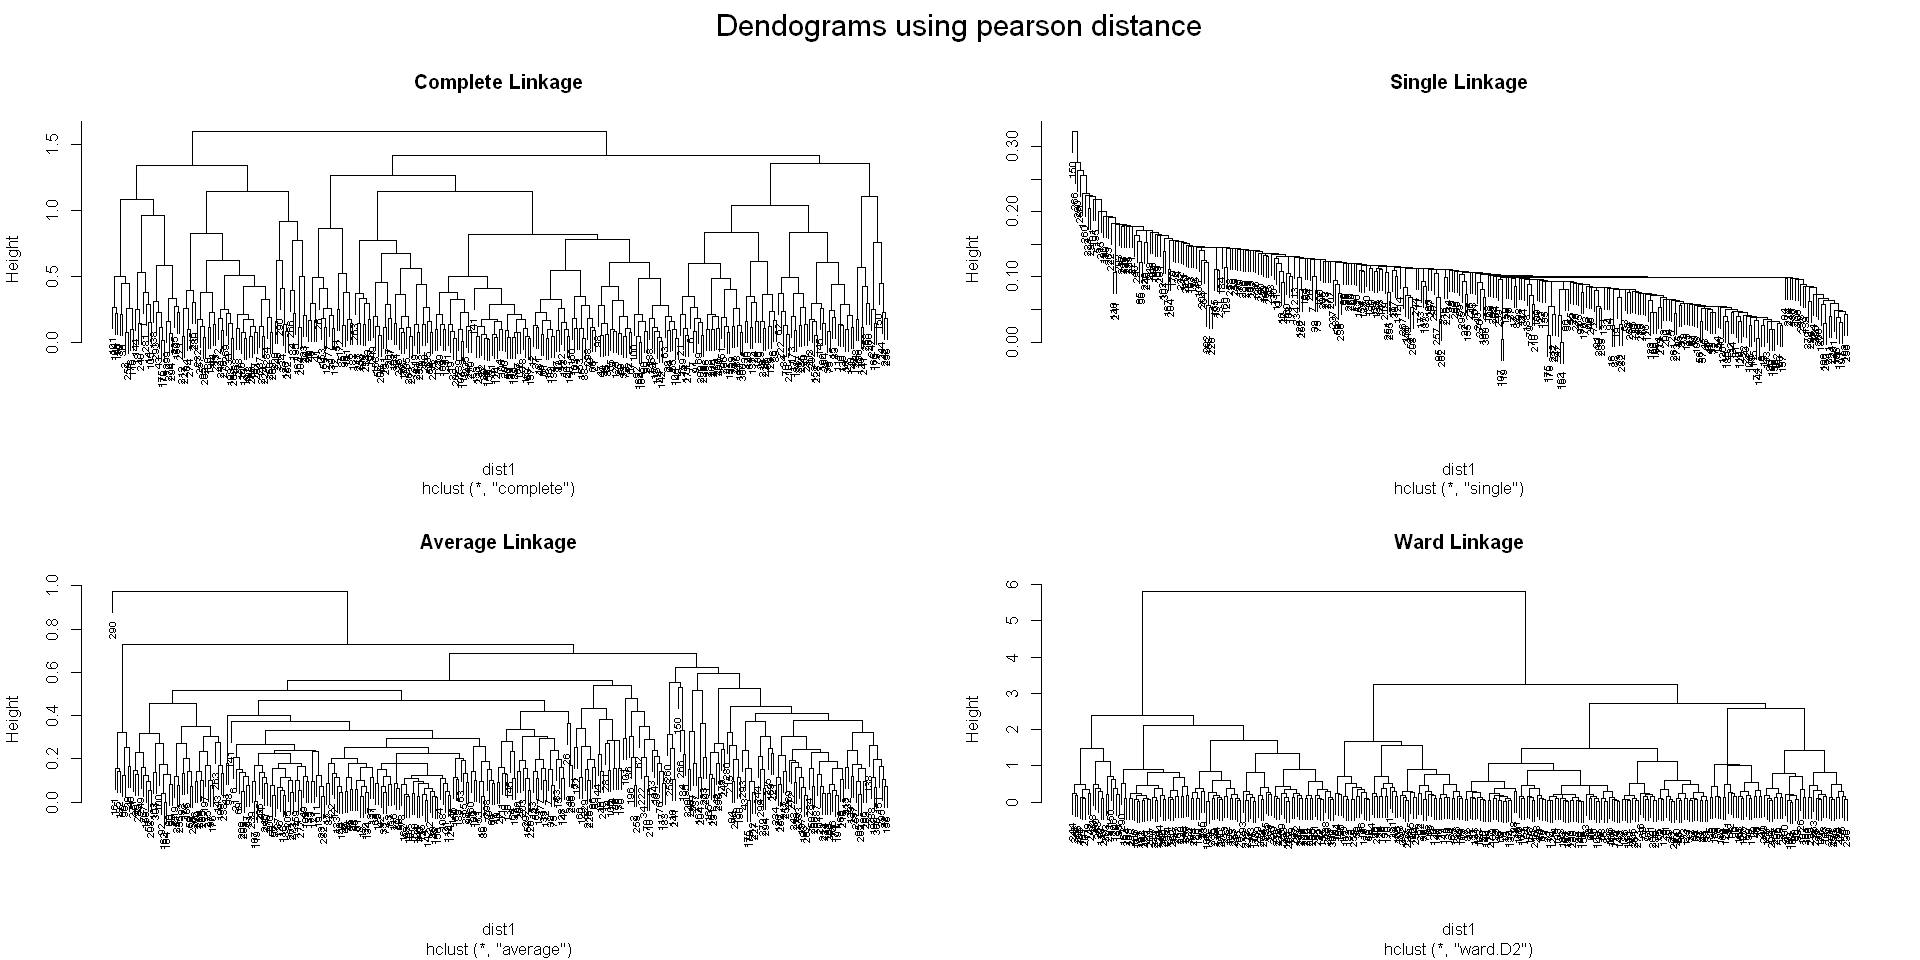

In [73]:
options(repr.plot.width = 16, repr.plot.height = 8)
plot_dendograms(hclus11,hclus12,hclus13,hclus14,"Dendograms using pearson distance")

In the dendograms for pearson similarity, it is easy to notice that both average and single linkage favor a larger amount of clusters since if we choose a higher cutoff there will be clusters with close to no samples. As for structure single linkage stands out from the others for its unusual splitting pattern. For pearson distance the only linkages that favor k=2 are **ward** and complete **linkage**.

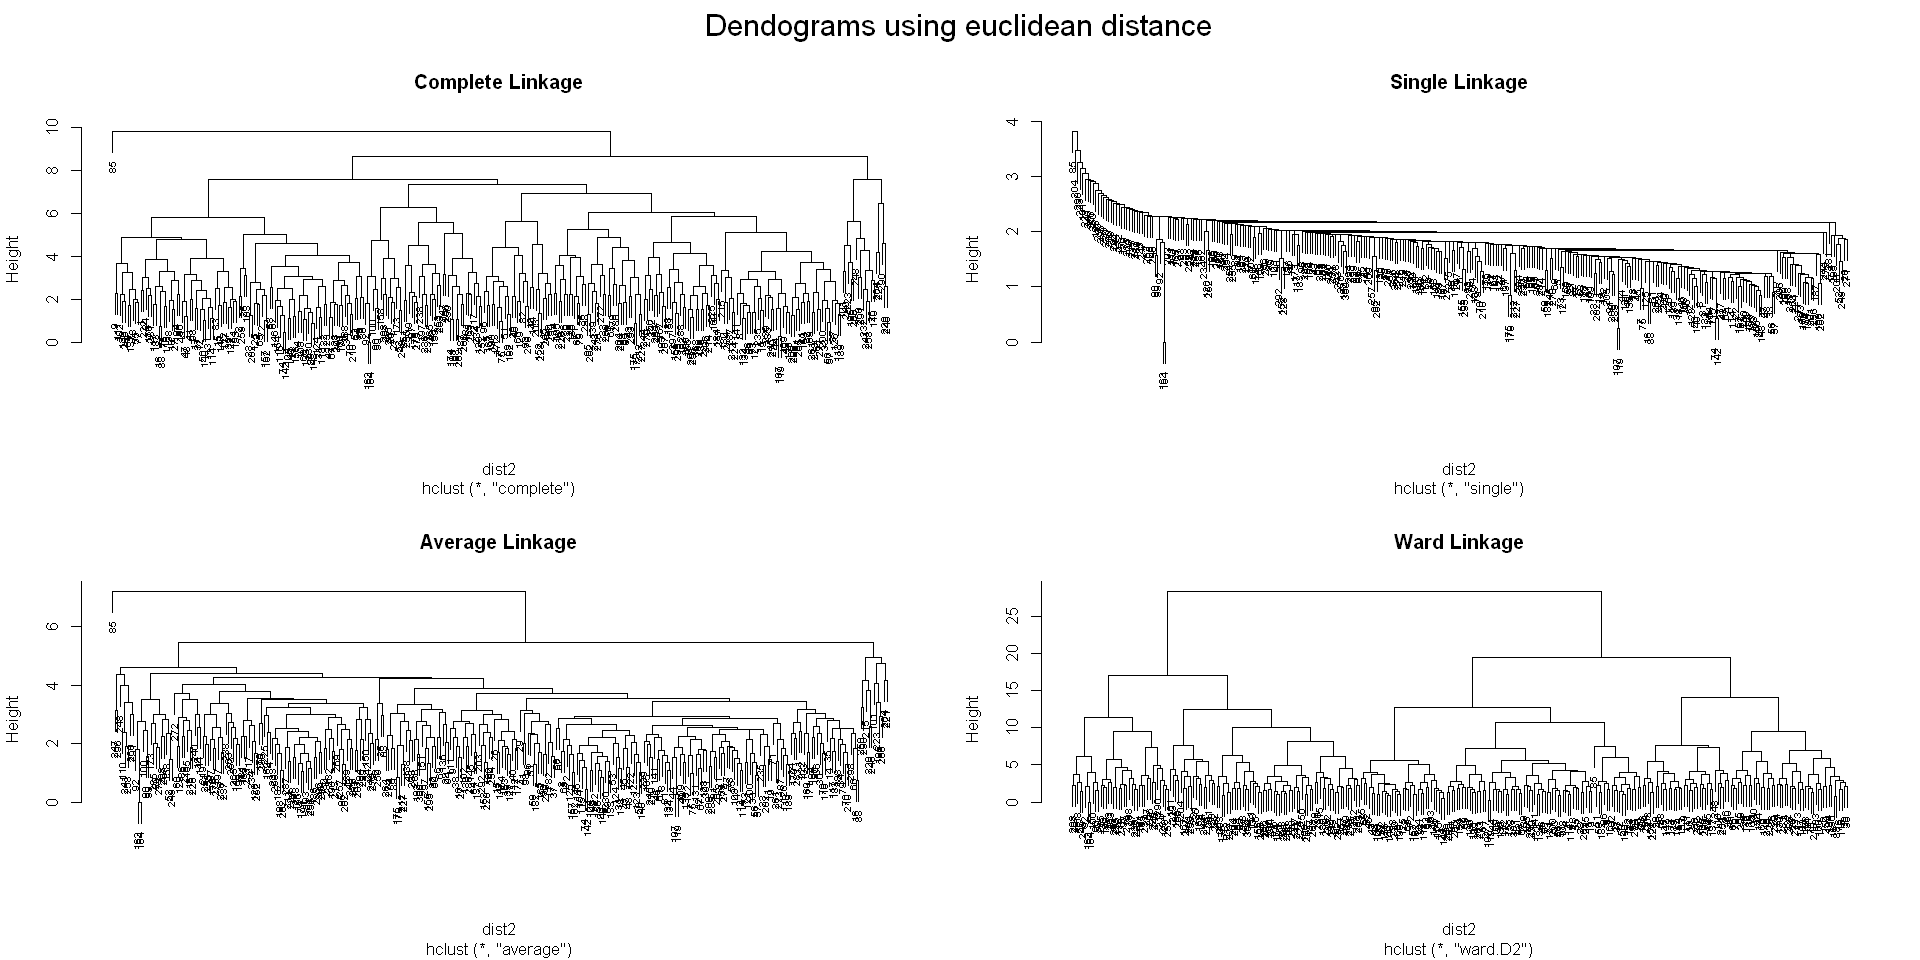

In [74]:
plot_dendograms(hclus21,hclus22,hclus23,hclus24,"Dendograms using euclidean distance")

As for euclidean distance there seems to be a similar pattern to pearson similarity but this time complete linkage does not favor k=2 as the meaningful splits only happen after height 8. 

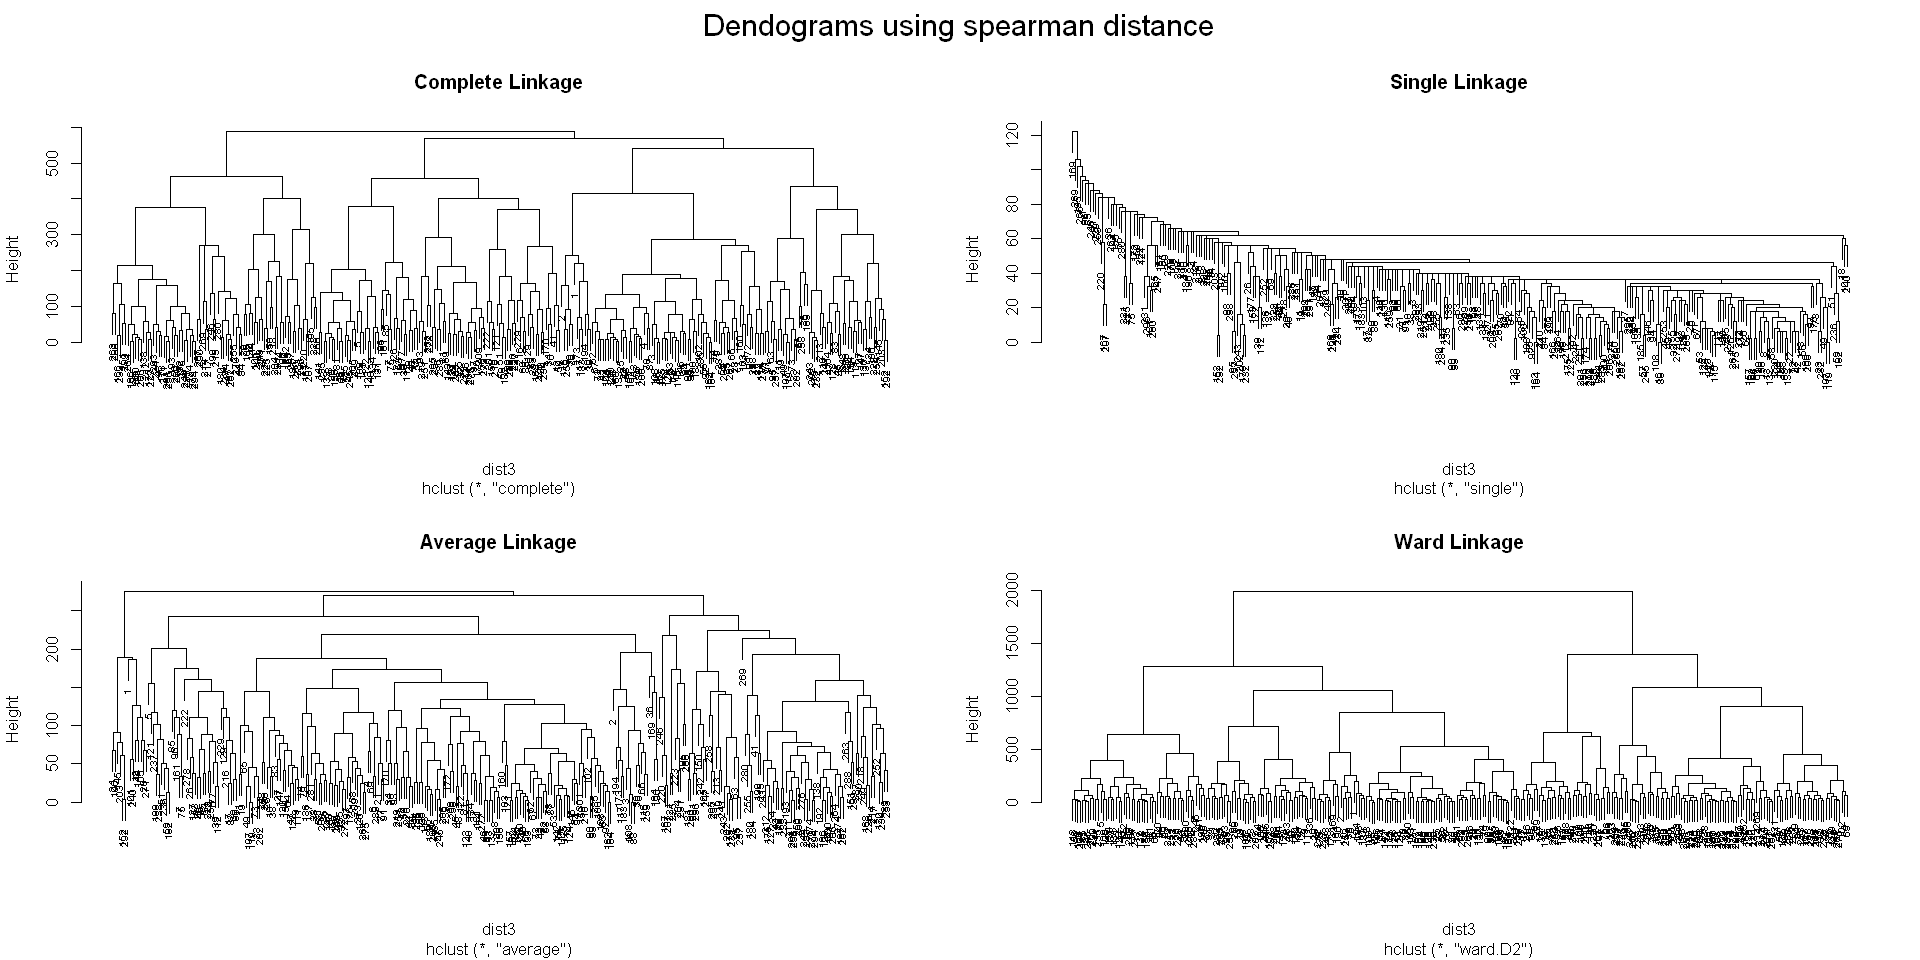

In [75]:
plot_dendograms(hclus31,hclus32,hclus33,hclus34,"Dendograms using spearman distance")

As per the previous observation complete and average linkage seem to follow a similar structure but this time there seems to be less
imbalanceness. As for ward linkage it seems to be benefitting smaller numbers of k with balanced clusters like in the previous example.

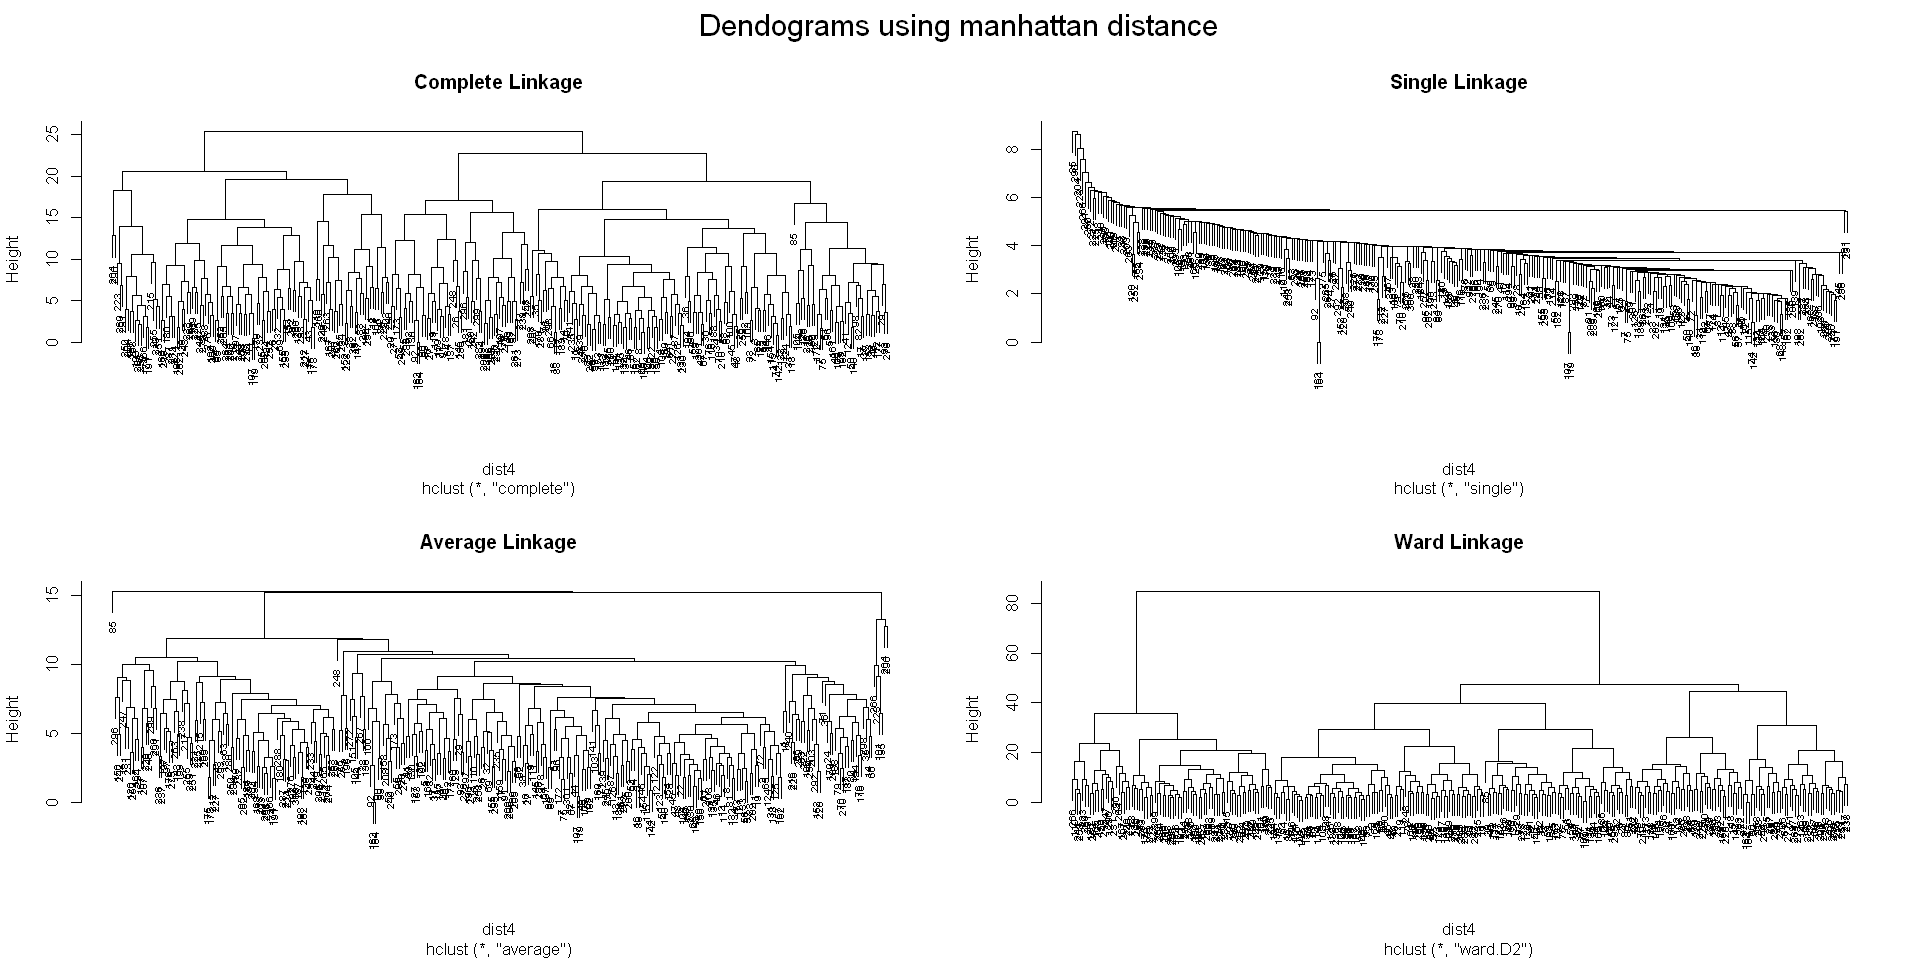

In [76]:
plot_dendograms(hclus41,hclus42,hclus43,hclus44,"Dendograms using manhattan distance")

In this case like in the pearson case, average linkage and complete linkage seem to follow different splitting structures with complete linkage and ward linkage being similar.

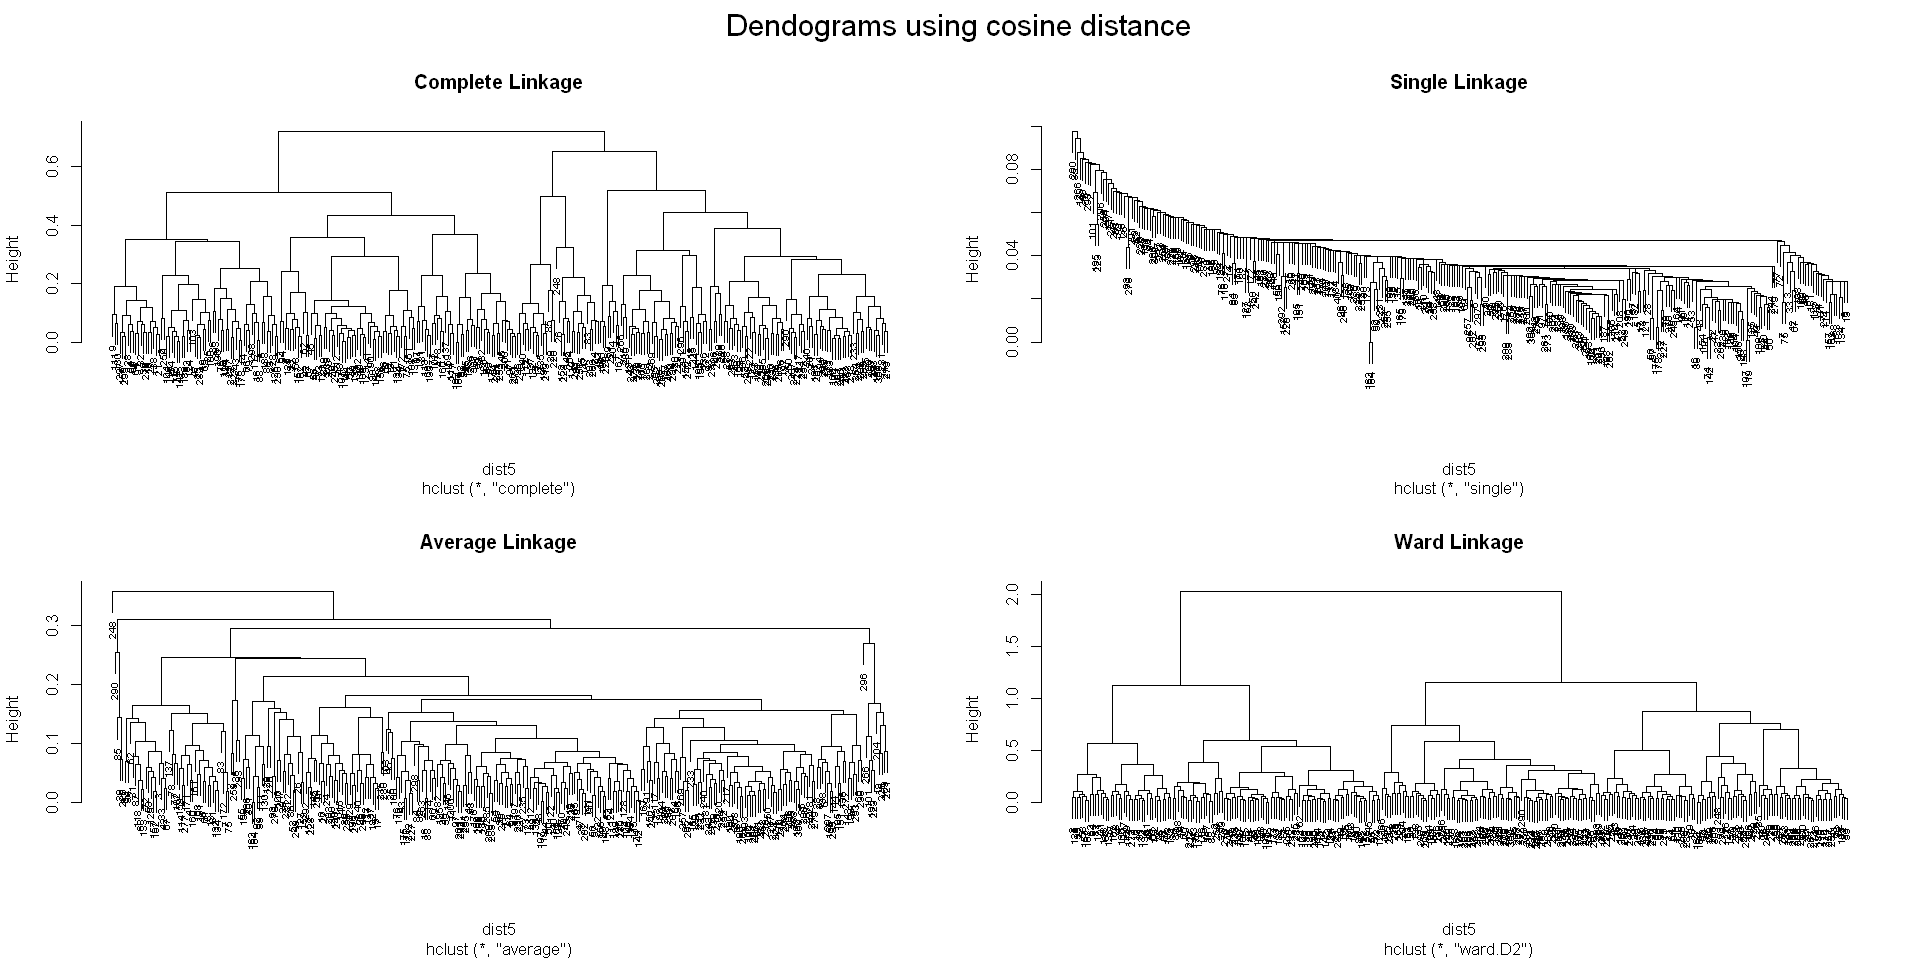

In [77]:
plot_dendograms(hclus51,hclus52,hclus53,hclus54,"Dendograms using cosine distance")

As for cosine similarity there doesn't seem to be much difference from cosine distance

In conclusion it seems that both complete and ward linkage can be appropriate for k=2 while average linkage is very imbalanced using most distance measures and single linkage is, as far as our expirements, only godo for larger number of k.

### Agglomeration Coefficent

"The agglomerative coefficient measures the dissimilarity of an object to the first cluster it joins, divided by the dissimilarity of the final merger in the cluster analysis, averaged across all samples. Larger values reflect tight clustering of objects, lower values indicate less well-formed clusters. The agglomerative coefficient increases with sample sizes, making comparisons among data sets difficult"
[[1]](https://www.rdocumentation.org/packages/cluster/versions/2.1.0/topics/agnes)

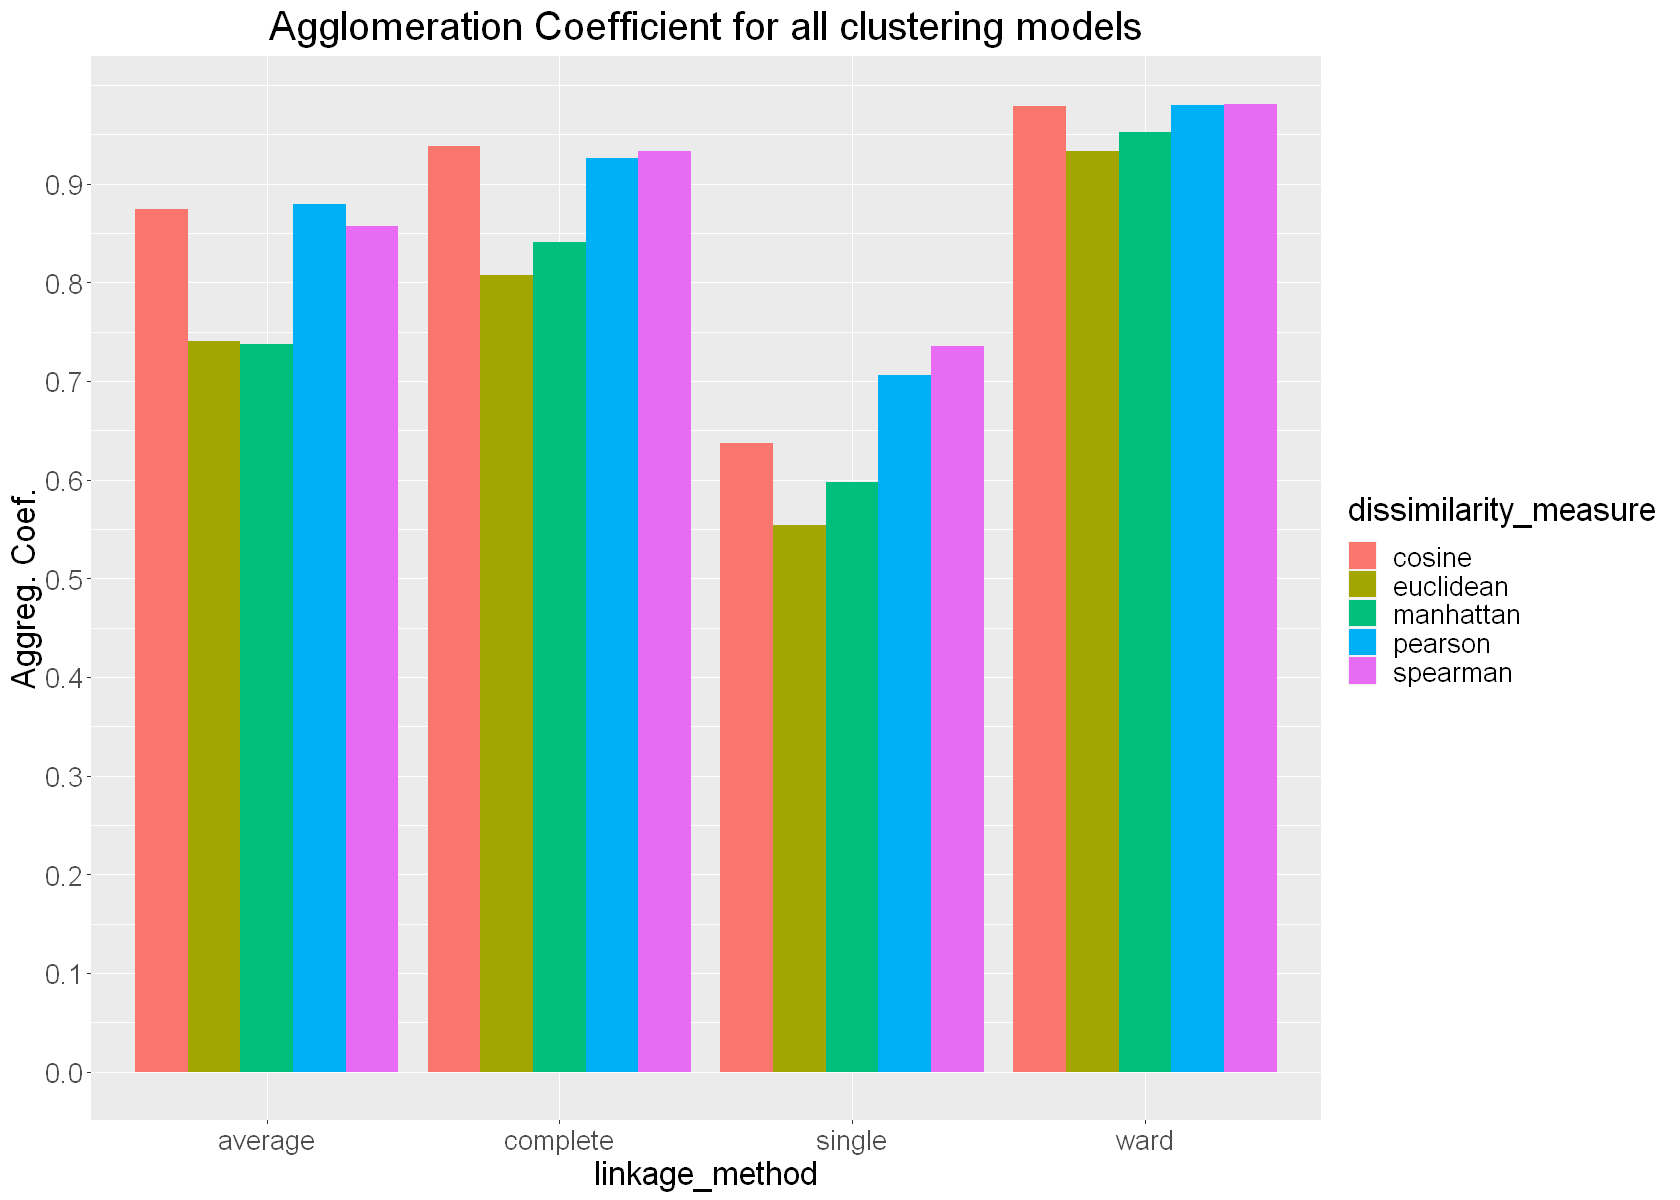

In [78]:
options(repr.plot.width = 14, repr.plot.height = 10)
plot_metrics(results_data,agregation_coef,0.1,"Agglomeration Coefficient for all clustering models","Aggreg. Coef.")

When it comes to agglomeration coeficient we can observer that most linkage methods have a fairly high value, even single linkage which was detirmined be worse for 2 clusters still has a fairly good value (~0.6). The best being ward linkage with ~0.95.

As for the dissimilarity measures all measures perform fairly equaly with euclidean and manhattan being the worst across all linkage methods.

### Ajusted Rand Index

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)

The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation). [[2]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)

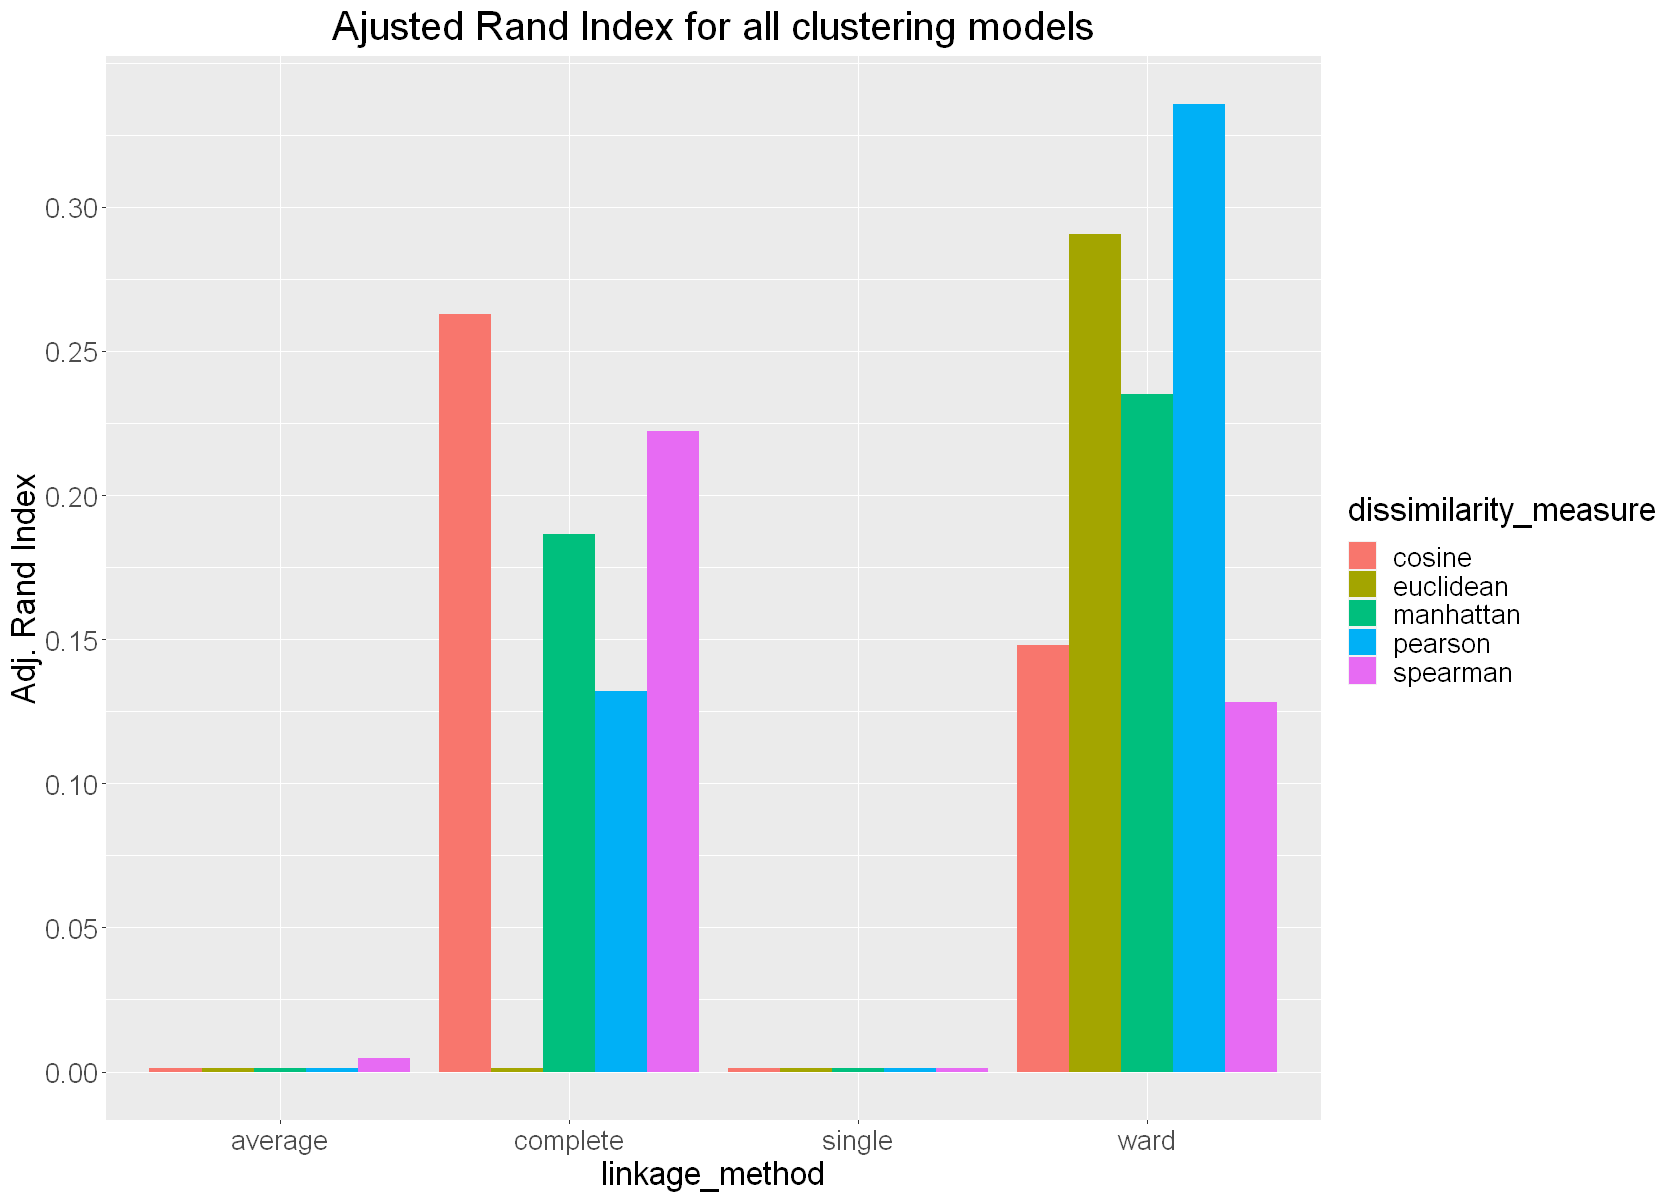

In [79]:
plot_metrics(results_data,rand_index,0.05,"Ajusted Rand Index for all clustering models","Adj. Rand Index")

As exptected from the dendogram readings both average and single linkage perform very bad in terms of rand index both with around 0.

As for dissimilarity measures, Ward seems to outperform complete linkage in euclidean, manhattan and pearson distances while complete is better in cosine and spearman distances.

The **best** model in this metric seems to be pearson similarity with ward linkage.

### Recall

Recall can be seen as the ratio between true positives(TP) and true positives + false negatives ( **TP/(TP+FN)** ) or in other words the ratio between the people correctly indetified as having heart disease and all the people that actualy have the disease

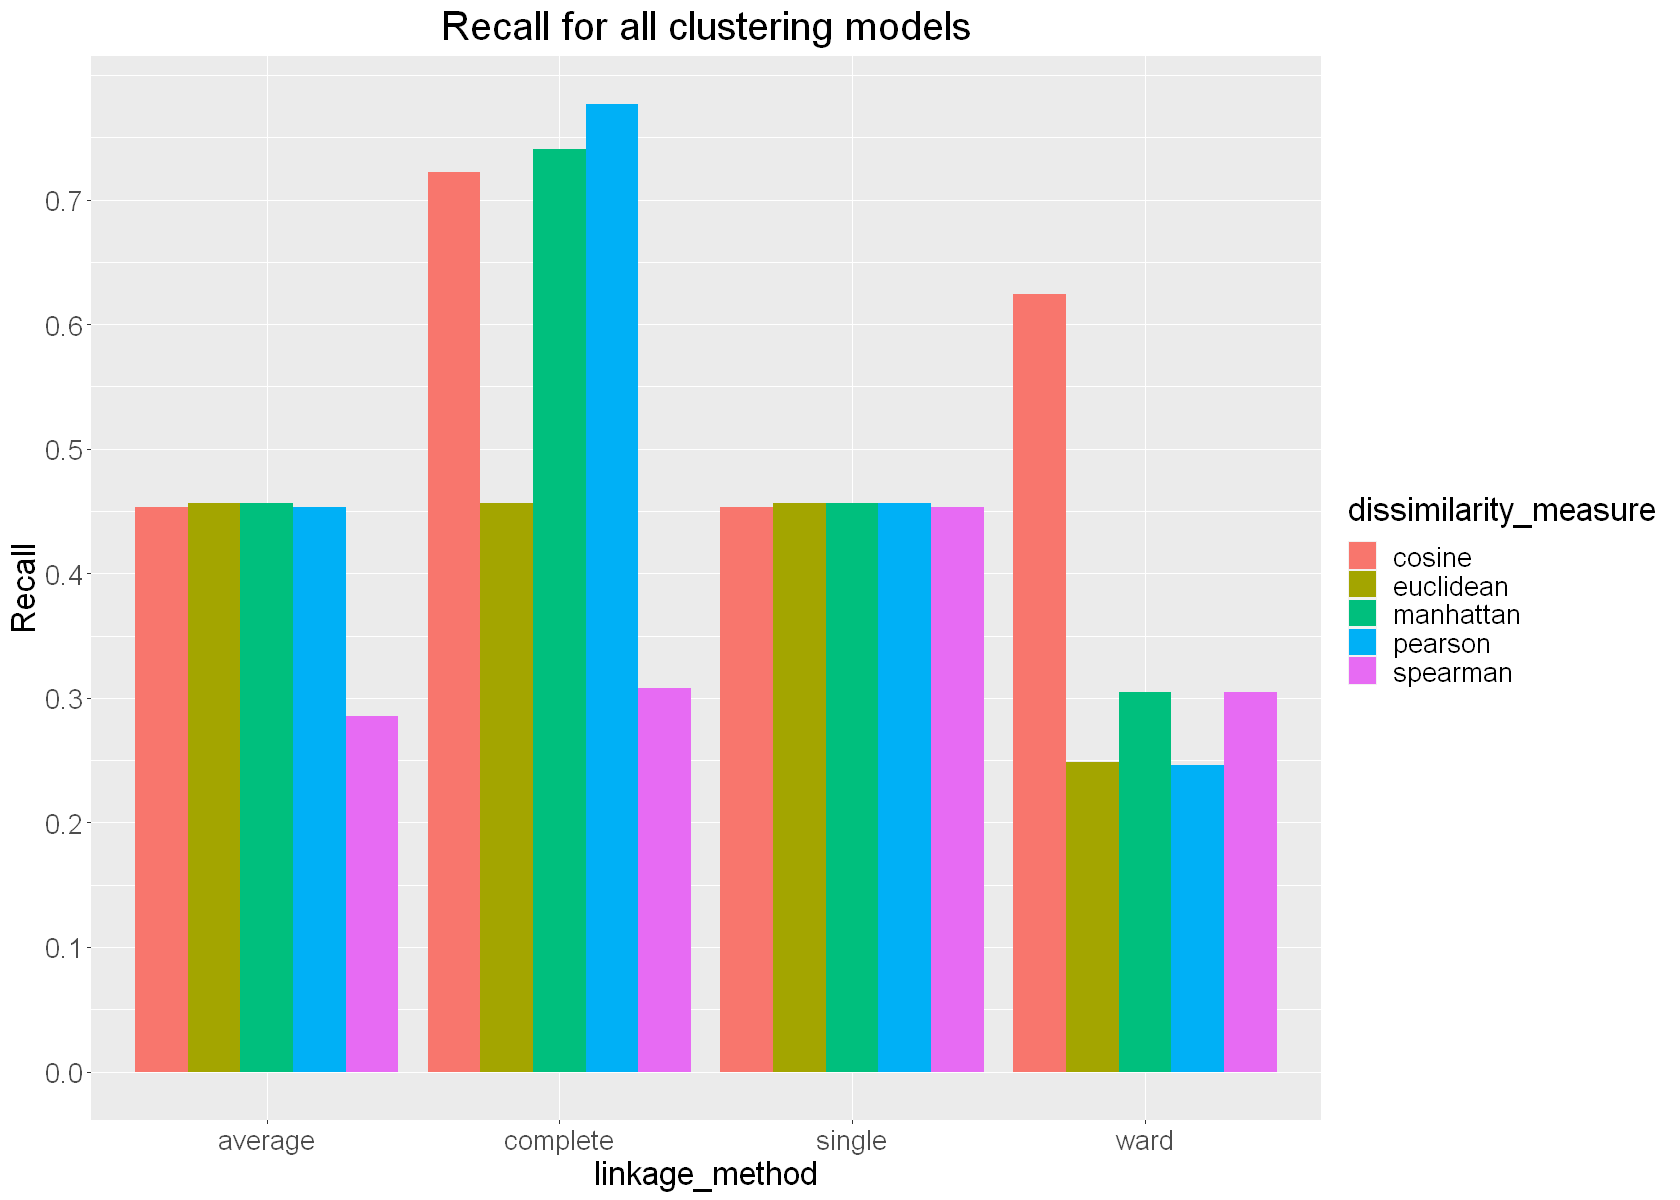

In [80]:
plot_metrics(results_data,recall,0.1,"Recall for all clustering models","Recall")

Recall was previously mention as being very important in the medical field as it is often better to trade more false positives for less false negatives.

In this case we can consider both average and single linkage random models since these are classifying all the datapoints as positive.

As for ward and complete there is a clear advantange for **complete** linkage mainly when talking about **manhattan** and **pearson** distances.

### Precision

Similarly to recall precision is the ratio between true positives and true positives + false positives (**TP/(TP+FP)**). More specifically recall is the ratio between the people correctly predicted as having heart diseas and all the people predicted as having heart disease.

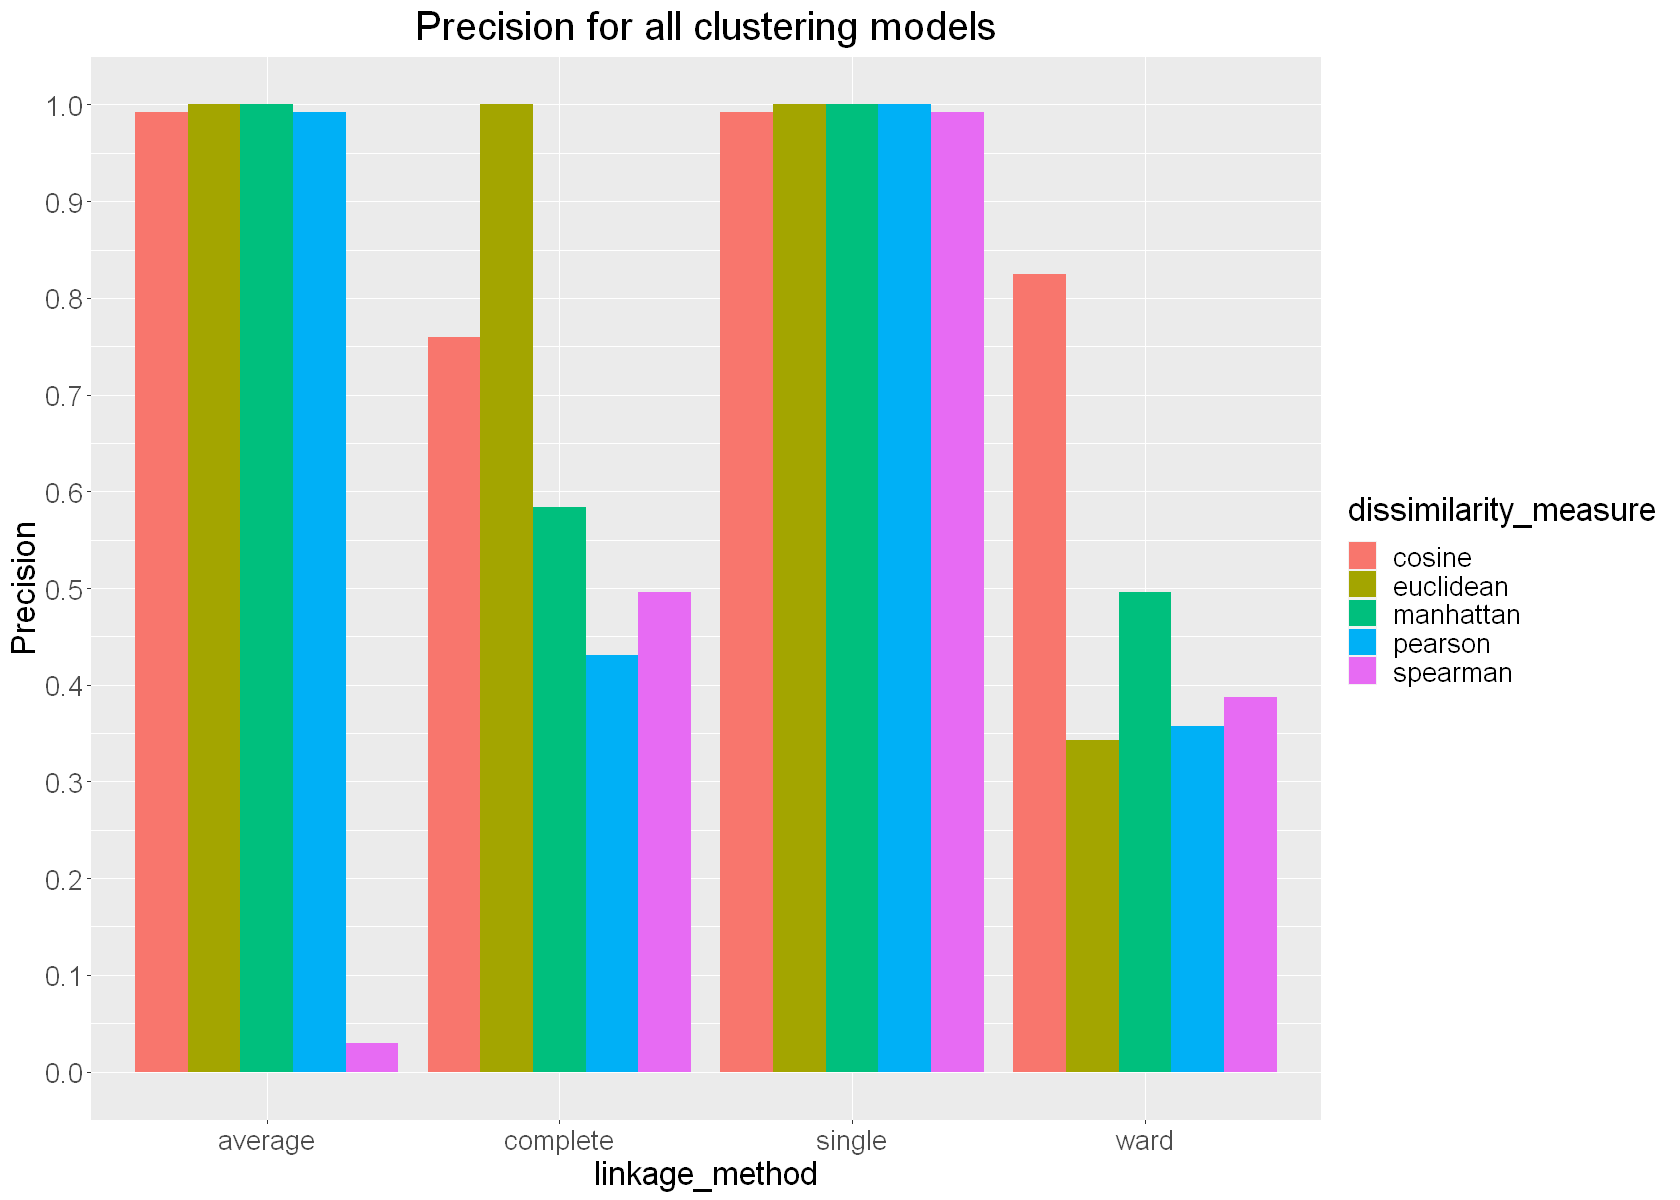

In [81]:
plot_metrics(results_data,precision,0.1,"Precision for all clustering models","Precision")

As expected precision is very high when recall is very low for both average and single linkage. This cannot be taken seriously since these models are "random models".

When taking into account recall the best precision values are those of complete linkage with cosine manhattan and pearson distances and ward linkage with cosine linkage.

One could argue that the best model is cosine similarity with complete linkage since it has one of the best recalls (0.73) and still has around 0.75 precision.

### F5

F-beat when beta=1 is the harmonic mean of the recall and precision have the same weight. In this case we set beta=5 so recall is to be considered 5 times as important as precision.


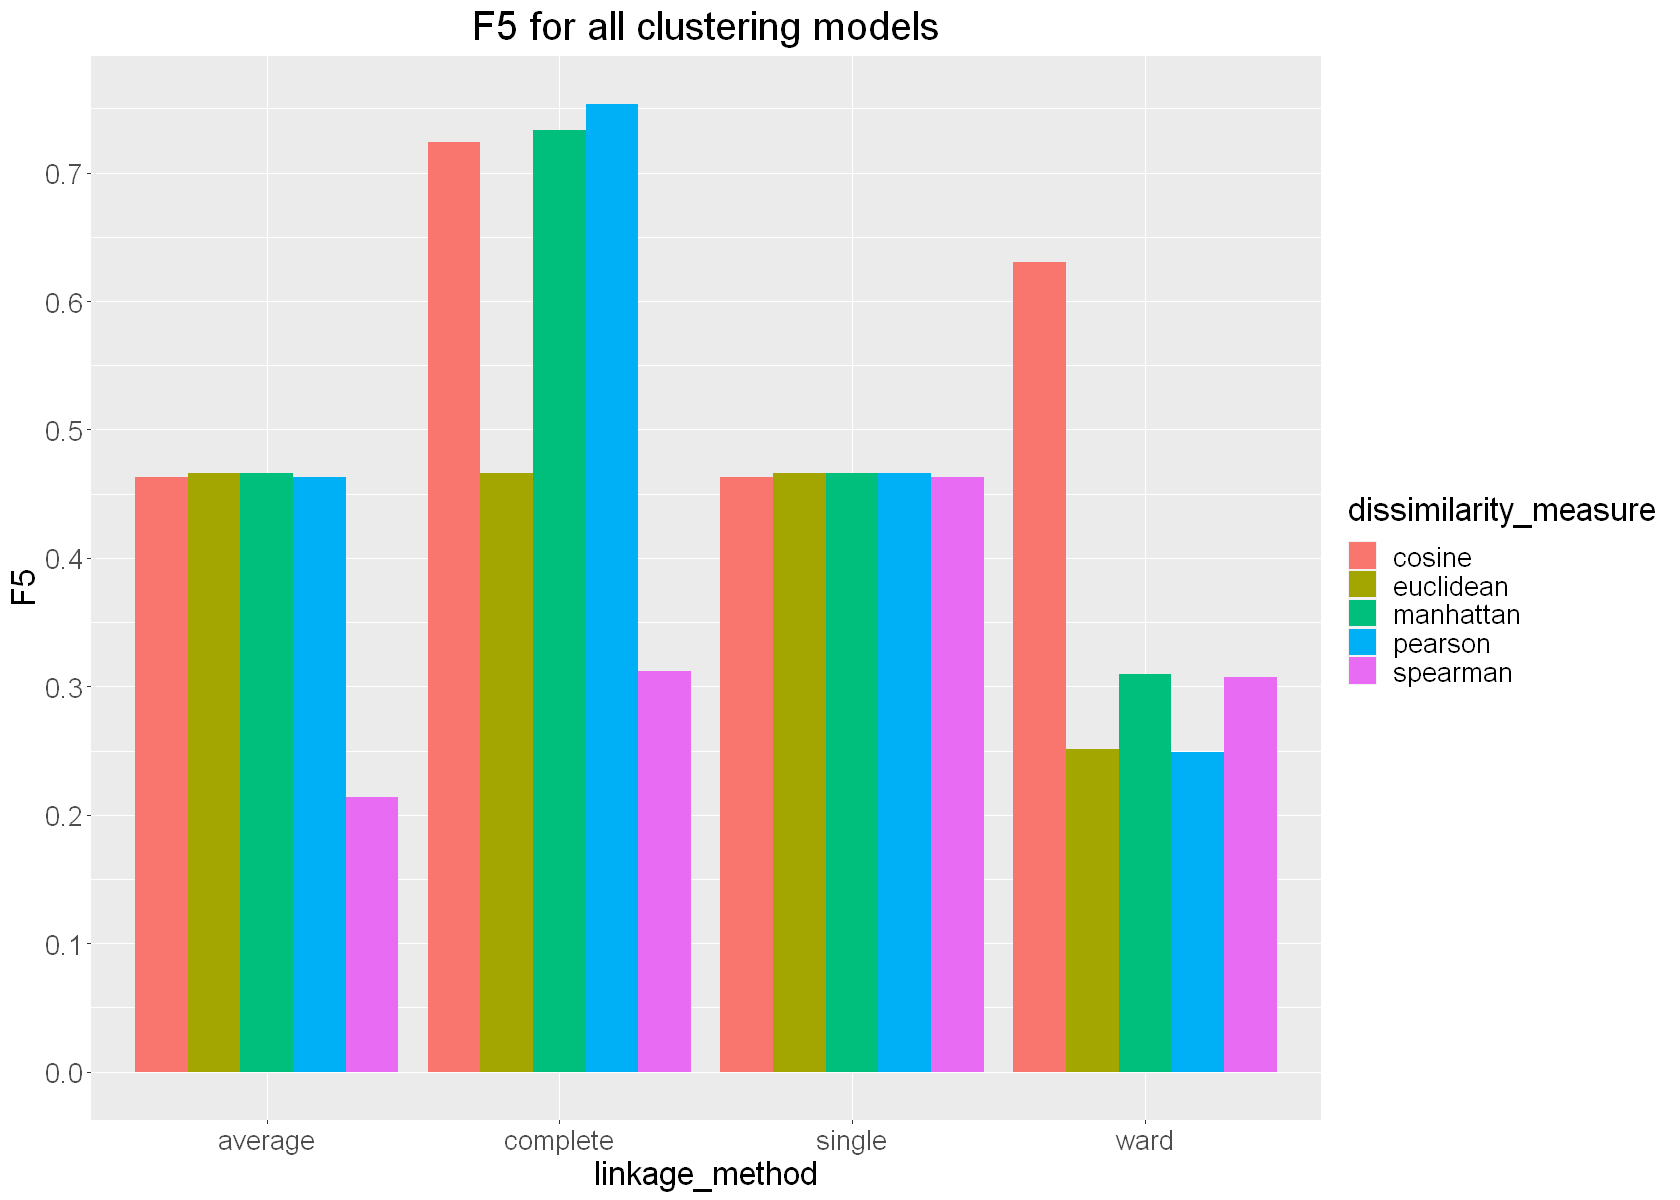

In [82]:
plot_metrics(results_data,f5,0.1,"F5 for all clustering models","F5")

The results ar as exptected from the previous recall analysis tending towards complete linkage more specifically towards cosine pearson and manhattan distances where f5 is around 0.7.

### Conclusion

While hierachical clustering is for sure a very powerfull technique. The dataset in question does not seem to benefit much from the techniques we experimented. As such we recommend the usage of the other techniques when in a classification setting.

### References
[1] - https://www.rdocumentation.org/packages/cluster/versions/2.1.0/topics/agnes

[2] - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html